#Reading datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('drive/Shared drives')
os.chdir('RL Final Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

In [ ]:
import pandas as pd
df = pd.read_csv('journeys.csv')
journeys = df
journeys.head()

,Trip ID Hash,Car ID Hash,Car Parking Address Postcode,Car Parking Address City,Trip Start At Local Time,Trip End At Local Time,Trip Created At Local Time,Trip Sum Trip Price
0,00010247034d28272cf5e1e16b43f52f,9ddac6a5fb0b3962db3b2f42fd31d3f9,94110,San Francisco,2017-11-14 22:15:00,2017-11-15 02:15:00,2017-11-14 20:32:59,$20.00
1,0001556e5d28e66b3318e89c094186c4,0f386ec90e0710ca143922520eaf8a3e,94117,San Francisco,2017-12-07 17:00:00,2017-12-08 04:00:00,2017-12-07 04:51:42,$55.00
2,000286e8771651e6983555c62558b57f,63e4509c686d891f5364c24339369460,94115,San Francisco,2017-03-23 10:00:00,2017-03-23 12:00:00,2017-03-23 08:49:48,$18.00
3,0003651ffd2f07a7226fd6b7c979fecb,c9fbe5bf8e406cd13bd33ff5411fa3e3,94103,San Francisco,2017-07-05 19:00:00,2017-07-06 01:45:00,2017-07-05 01:07:31,$33.75
4,000416e4334896da4a366e17ce42152e,48275fb73951c77021f9d820d15c5139,2118,Boston,2017-01-24 09:00:00,2017-01-24 11:30:00,2017-01-22 22:47:11,$21.25


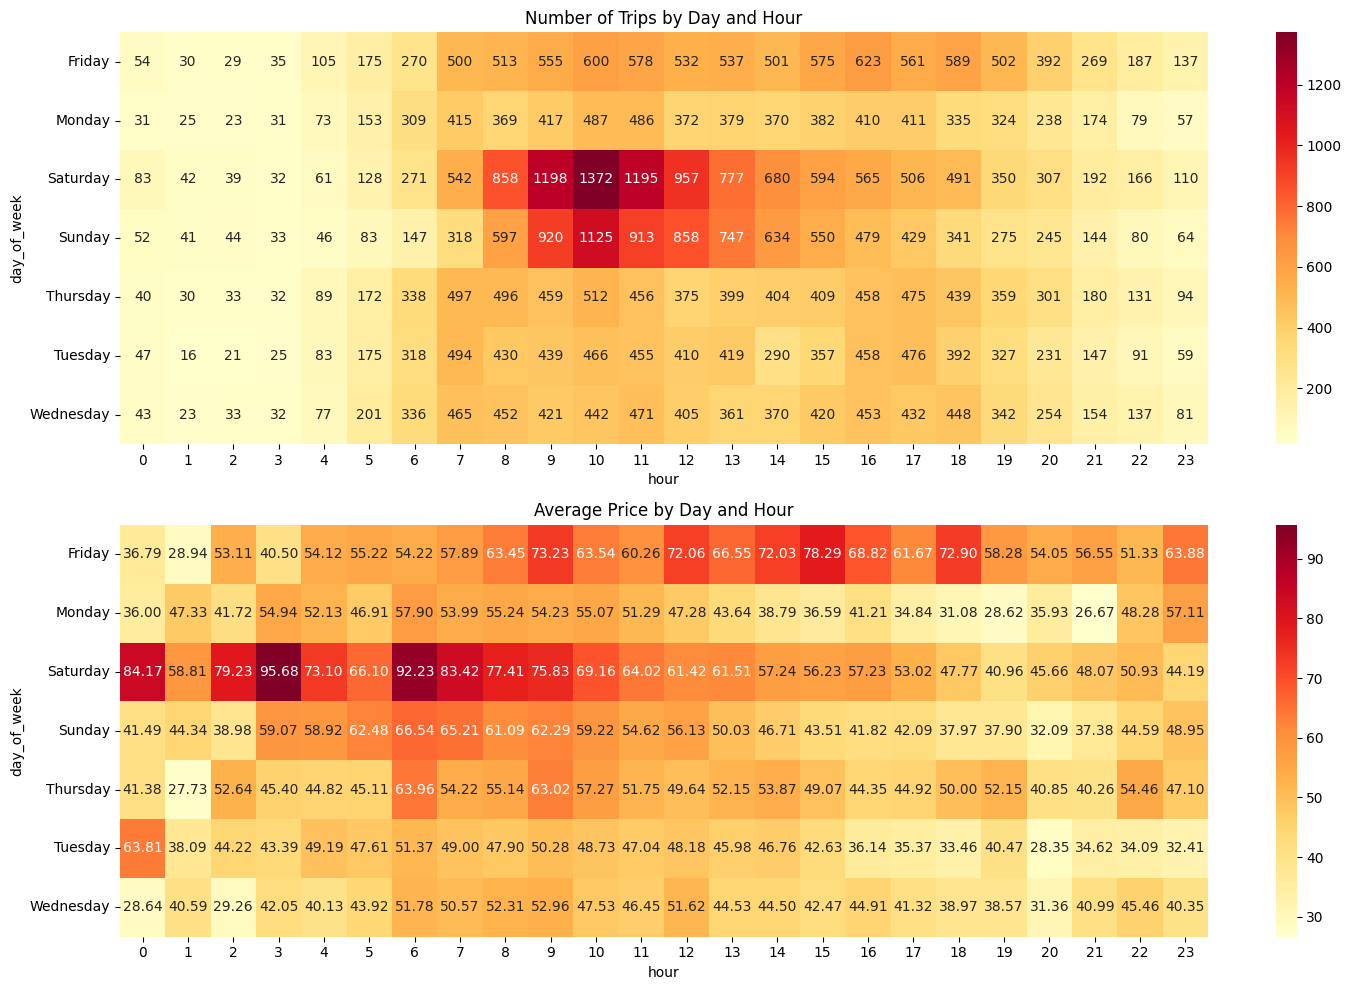


Hourly Statistics:
     Trip Sum Trip Price              Duration (Hour)
                    mean    std count            mean
hour                                                 
0                  51.80  87.14   350           11.21
1                  42.10  62.32   207            8.91
2                  49.26  66.97   222            9.71
3                  54.61  66.36   220           11.08
4                  52.10  38.09   534           10.32
5                  50.97  45.88  1087            9.77
6                  61.67  68.77  1989           12.81
7                  59.42  50.46  3231           11.24
8                  61.21  55.35  3715           11.17
9                  64.57  59.77  4409           11.57
10                 59.85  56.21  5004           10.47
11                 55.56  51.67  4554            9.35
12                 56.83  67.43  3909            9.79
13                 53.49  55.20  3619            9.21
14                 52.56  59.68  3249            9.53
15      

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate duration first
journeys['Trip Start At Local Time'] = pd.to_datetime(journeys['Trip Start At Local Time'])
journeys['Trip End At Local Time'] = pd.to_datetime(journeys['Trip End At Local Time'])
journeys['Duration (Hour)'] = (journeys['Trip End At Local Time'] - journeys['Trip Start At Local Time']).dt.total_seconds() / 3600

# Extract time features
journeys['day_of_week'] = journeys['Trip Start At Local Time'].dt.day_name()
journeys['hour'] = journeys['Trip Start At Local Time'].dt.hour

# Trip Sum Trip Price preprocessing - remove $ and comma
journeys['Trip Sum Trip Price'] = journeys['Trip Sum Trip Price'].str.replace('$', '').str.replace(',', '').astype(float)

# Time pattern analysis
time_patterns = journeys.groupby(['day_of_week', 'hour']).agg({
   'Trip ID Hash': 'count',
   'Trip Sum Trip Price': 'mean',
   'Duration (Hour)': 'mean'
}).reset_index()

# Visualization
plt.figure(figsize=(15, 10))

# 1. Number of trips by day/hour
plt.subplot(2,1,1)
pivot_data = time_patterns.pivot(index='day_of_week', columns='hour', values='Trip ID Hash')
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd')
plt.title('Number of Trips by Day and Hour')

# 2. Average price by day/hour
plt.subplot(2,1,2)
pivot_price = time_patterns.pivot(index='day_of_week', columns='hour', values='Trip Sum Trip Price')
sns.heatmap(pivot_price, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Average Price by Day and Hour')

plt.tight_layout()
plt.show()

# Detailed statistics
print("\nHourly Statistics:")
hourly_stats = journeys.groupby('hour').agg({
   'Trip Sum Trip Price': ['mean', 'std', 'count'],
   'Duration (Hour)': 'mean'
}).round(2)
print(hourly_stats)

# Identify most profitable hours
profitable_hours = hourly_stats['Trip Sum Trip Price']['mean'].sort_values(ascending=False).head()
print("\nMost Profitable Hours:")
print(profitable_hours)

#Trips Pattern:</br>
Peak demand time: Saturday and Sunday 9-11AM (800-1300+ items)</br>
Weekday peak: 7-11AM, 4-6PM</br>
Minimum demand: 1-4AM (all days)</br>

#Price Pattern:</br>
Highest price range: </br>

Saturday 3AM ($95.68) </br>

Saturday 12AM ($84.17)</br>

Saturday 6AM ($92.23)</br>

#Weekday prices:</br>
High overall price range on Friday</br>
Mid-day (7-11AM) on weekdays</br>
Relatively low price range in the evening</br>

# Finding the Probability Distribution


#### Acquire all the hourly rate from trips available and take the ratio of their frequency to the sum of all trips as its probability. Fit the distribution with Gaussian Distribution (Normal Distribution) to get the probability distribution correlation in our case.
(Similar to true_probs = [0.9, 0.8, 0.7, 0.6, 0.5])

Fitted Gaussian Parameters: a=0.1618, mu=6.5152, sigma=2.4761


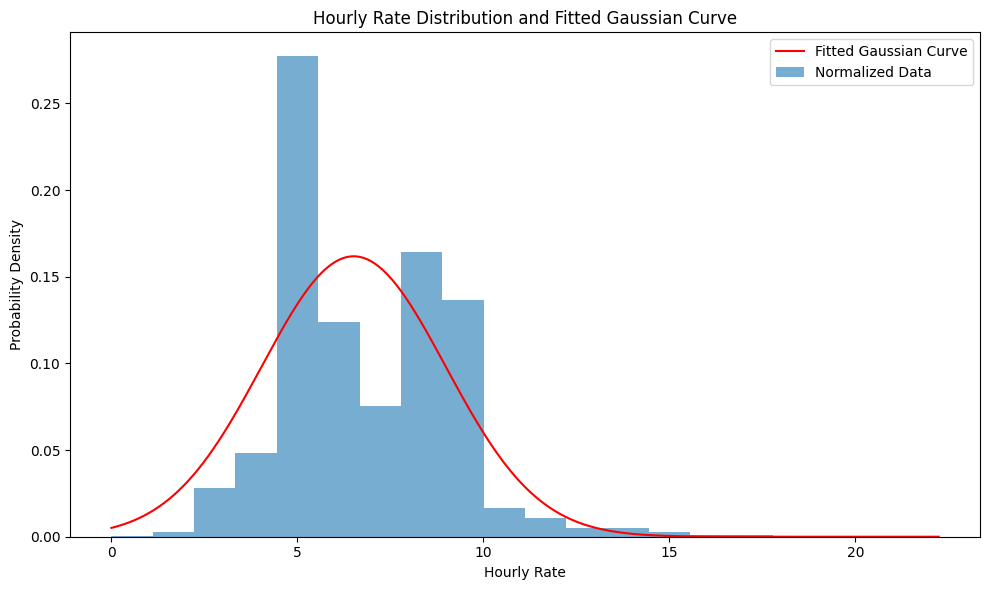

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import quad

df = pd.read_csv('journeys.csv')

# Work out the hourly rate based on the dataset
df['Trip Start At Local Time'] = pd.to_datetime(df['Trip Start At Local Time'])
df['Trip End At Local Time'] = pd.to_datetime(df['Trip End At Local Time'])
df['Duration (Hour)'] = (df['Trip End At Local Time'] - df['Trip Start At Local Time']).dt.total_seconds() / 3600
df['Trip Price'] = df['Trip Sum Trip Price'].str.extract(r'(\d+\.?\d*)').astype(float)
df['Hourly Rate'] = df['Trip Price'] / df['Duration (Hour)']

# Define a Gaussian function
def gaussian(x, a, mu, sigma):
    """Gaussian function for curve fitting.
    Args:
        x: The input variable.
        a: Amplitude of the Gaussian.
        mu: Mean of the Gaussian.
        sigma: Standard deviation of the Gaussian.
    Returns:
        Gaussian function value for input x.
    """
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Extract the 'Hourly Rate' column from the DataFrame
hourly_rates = df['Hourly Rate'].values

# Create a histogram of the data
counts, bin_edges = np.histogram(hourly_rates, bins=20, density=True)  # Generate a normalized histogram
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for visualization

# Remove invalid or zero-frequency bins
valid_indices = counts > 0  # Only keep bins with positive frequency
bin_centers = bin_centers[valid_indices]
counts = counts[valid_indices]

# Set initial guesses for the Gaussian parameters
p0 = [np.max(counts), bin_centers[np.argmax(counts)], np.std(hourly_rates)]  # [amplitude, mean, std deviation]

# Fit the Gaussian curve to the histogram data
try:
    # Fit the Gaussian function using curve_fit
    params, _ = curve_fit(gaussian, bin_centers, counts, p0=p0, maxfev=5000)

    # Normalize the Gaussian to ensure its total area under the curve equals 1
    normalization_factor = quad(lambda x: gaussian(x, *params), bin_edges[0], bin_edges[-1])[0]  # Compute total area
    params[0] /= normalization_factor  # Adjust amplitude (a) for normalization

    # Print the fitted Gaussian parameters
    print(f"Fitted Gaussian Parameters: a={params[0]:.4f}, mu={params[1]:.4f}, sigma={params[2]:.4f}")

    x_plot = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    y_plot = gaussian(x_plot, *params)
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, counts, width=bin_edges[1] - bin_edges[0], alpha=0.6, label='Normalized Data')
    plt.plot(x_plot, y_plot, label='Fitted Gaussian Curve', color='red')
    plt.title('Hourly Rate Distribution and Fitted Gaussian Curve')
    plt.xlabel('Hourly Rate')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

except RuntimeError as e:
    print(f"Could not fit data: {e}")

## Use the fitted gaussian to generate the utilization rate distribution and run simulation over it.

Thompson Sampling Results:
Selection Counts: [ 34.  34.  47.  55.  34.  62.  64. 105. 105. 313. 313. 333. 499. 871.
 423.  31. 338. 257. 122. 210.  55.  47.  45.  39.  48.  35.  33.  33.
  35.  34.  35.  36.  35.  32.  33.  34.  37.  34.  35.  35.]
Cumulative Rewards: 532
Epsilon-Greedy Results:
Selection Counts: [  44.   49.   38.   37.   39.   46.   41.   85.   46.   80.   49.   73.
   30.   61. 3152.   46.   31.   67.   38.  178.   37.   44.   58.   41.
   39.   30.   41.   34.   33.   36.   39.   28.   47.   32.   32.   39.
   43.   41.   40.   36.]
Cumulative Rewards: 599


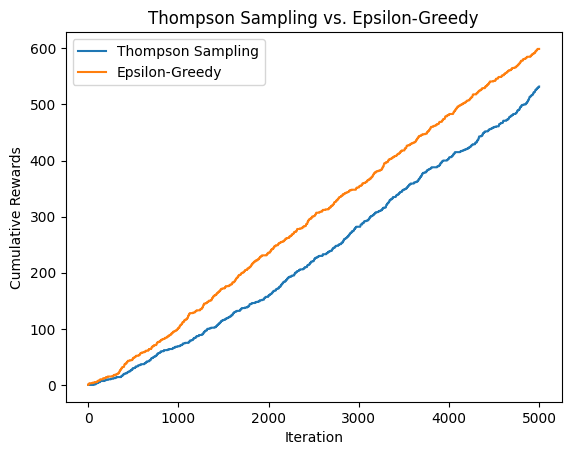

In [ ]:
# Simulation parameters
prices = np.arange(0, 20, 0.5)
true_utilization_rates = [gaussian(i, params[0], params[1], params[2]) for i in prices]  # True success

num_prices = len(true_utilization_rates)
num_iterations = 5000
epsilon = 0.3  # Exploration probability for Epsilon-Greedy

# Initialize variables for Thompson Sampling
successes = np.zeros(num_prices)
failures = np.zeros(num_prices)
th_rewards = []
th_selection_counts = np.zeros(num_prices)

# Initialize variables for Epsilon-Greedy
q_values = np.zeros(num_prices)
counts = np.zeros(num_prices)
eps_rewards = []
eps_selection_counts = np.zeros(num_prices)

for _ in range(num_iterations):
    # --- Thompson Sampling ---
    th_samples = [np.random.beta(successes[i] + 1, failures[i] + 1) for i in range(num_prices)]
    th_price_idx = np.argmax(th_samples)
    th_reward = 1 if np.random.rand() < true_utilization_rates[th_price_idx] else 0
    th_rewards.append(th_reward)
    th_selection_counts[th_price_idx] += 1
    if th_reward:
        successes[th_price_idx] += 1
    else:
        failures[th_price_idx] += 1

    # --- Epsilon-Greedy ---
    if np.random.rand() < epsilon:
        eps_price_idx = np.random.randint(num_prices)  # Explore
    else:
        eps_price_idx = np.argmax(q_values)  # Exploit
    eps_reward = 1 if np.random.rand() < true_utilization_rates[eps_price_idx] else 0
    eps_rewards.append(eps_reward)
    eps_selection_counts[eps_price_idx] += 1
    counts[eps_price_idx] += 1
    alpha = 1 / counts[eps_price_idx]  # Learning rate
    q_values[eps_price_idx] += alpha * (eps_reward - q_values[eps_price_idx])

print("Thompson Sampling Results:")
print(f"Selection Counts: {th_selection_counts}")
print(f"Cumulative Rewards: {np.sum(th_rewards)}")

print("Epsilon-Greedy Results:")
print(f"Selection Counts: {eps_selection_counts}")
print(f"Cumulative Rewards: {np.sum(eps_rewards)}")

plt.plot(np.cumsum(th_rewards), label="Thompson Sampling")
plt.plot(np.cumsum(eps_rewards), label="Epsilon-Greedy")
plt.xlabel("Iteration")
plt.ylabel("Cumulative Rewards")
plt.legend()
plt.title("Thompson Sampling vs. Epsilon-Greedy")
plt.show()

## Plot recommended price range by the two methods.

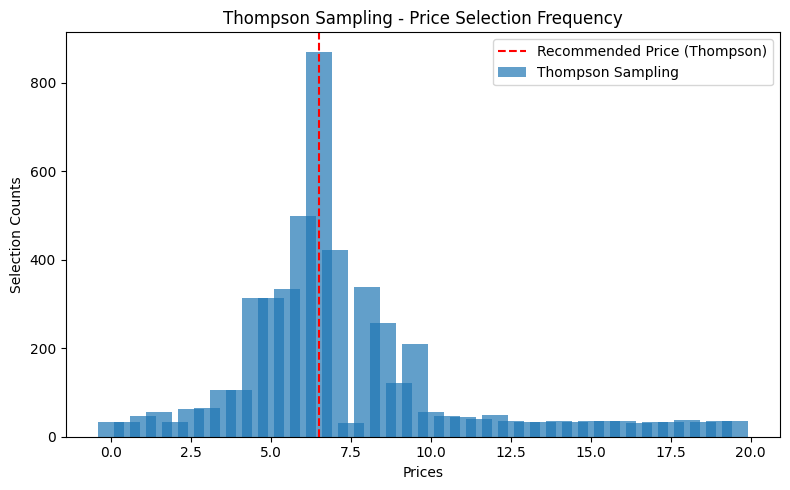

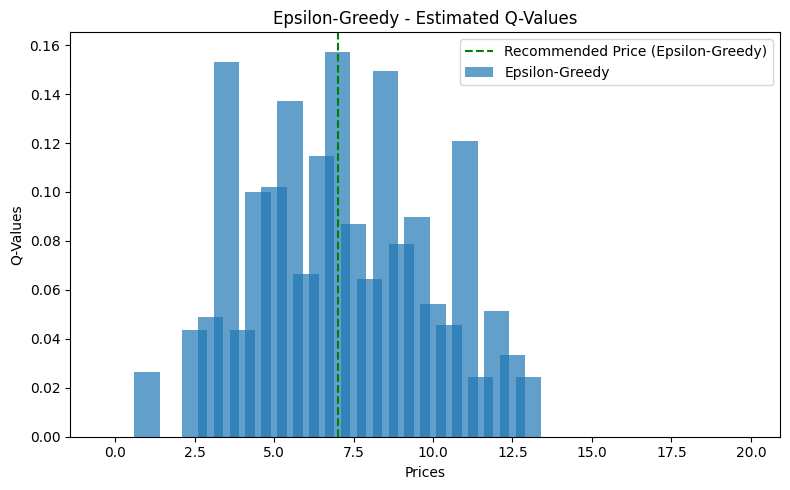

In [ ]:
# Calculate recommended prices
recommended_price_thompson = prices[np.argmax(th_selection_counts)]
recommended_price_epsilon = prices[np.argmax(q_values)]

# Plot selection counts for Thompson Sampling
plt.figure(figsize=(8, 5))
plt.bar(prices, th_selection_counts, alpha=0.7, label="Thompson Sampling")
plt.axvline(recommended_price_thompson, color='red', linestyle='--', label="Recommended Price (Thompson)")
plt.xlabel("Prices")
plt.ylabel("Selection Counts")
plt.title("Thompson Sampling - Price Selection Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Q-values for Epsilon-Greedy
plt.figure(figsize=(8, 5))
plt.bar(prices, q_values, alpha=0.7, label="Epsilon-Greedy")
plt.axvline(recommended_price_epsilon, color='green', linestyle='--', label="Recommended Price (Epsilon-Greedy)")
plt.xlabel("Prices")
plt.ylabel("Q-Values")
plt.title("Epsilon-Greedy - Estimated Q-Values")
plt.legend()
plt.tight_layout()
plt.show()

# Finding the Optimal Actions

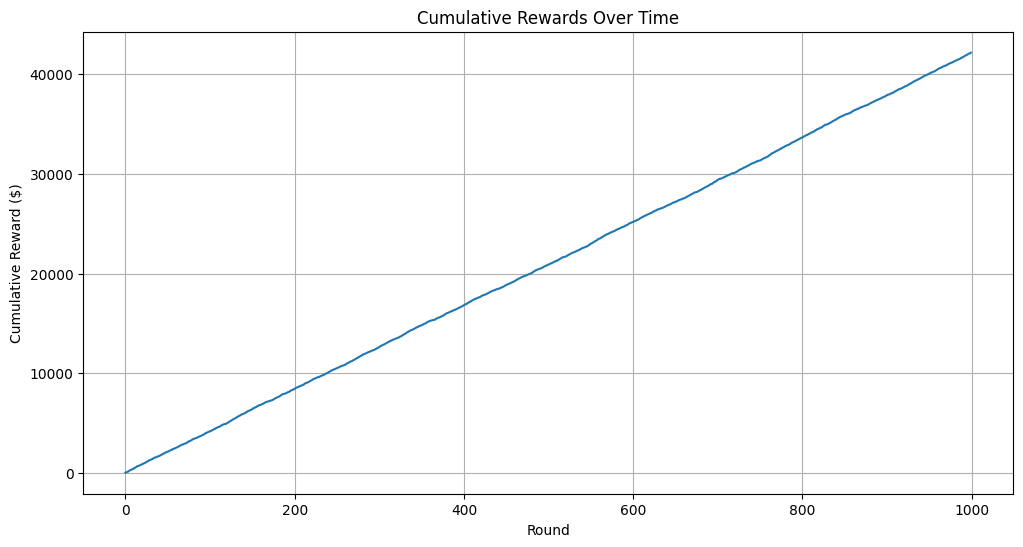

Average reward per round: $42.17


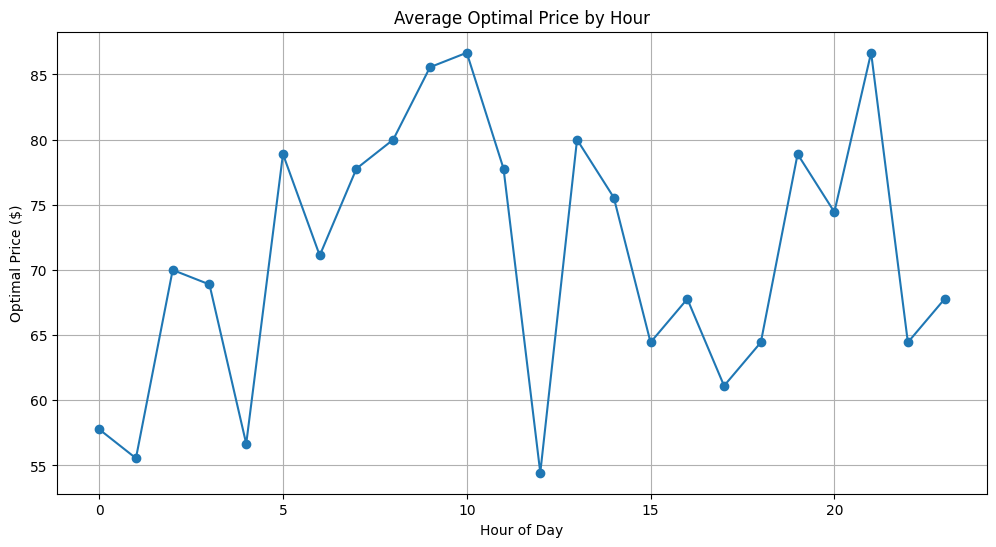

In [ ]:
# Load and preprocess the dataset
def preprocess_data(journeys):
    # Time features
    journeys['Trip Start At Local Time'] = pd.to_datetime(journeys['Trip Start At Local Time'])
    journeys['Trip End At Local Time'] = pd.to_datetime(journeys['Trip End At Local Time'])
    journeys['hour'] = journeys['Trip Start At Local Time'].dt.hour
    journeys['day_of_week'] = journeys['Trip Start At Local Time'].dt.day_name()

    # Calculate duration and clean price
    journeys['Duration (Hour)'] = (journeys['Trip End At Local Time'] - journeys['Trip Start At Local Time']).dt.total_seconds() / 3600
    journeys['Trip Price'] = journeys['Trip Sum Trip Price'].str.replace('$', '').str.replace(',', '').astype(float)

    return journeys

# Define success metrics based on time patterns
def calculate_success_probability(hour, day, price):
    # Higher success probability during peak hours
    peak_hours = [9, 10, 11]  # Based on heatmap
    weekend_days = ['Saturday', 'Sunday']

    base_prob = 0.5

    # Time-based adjustments
    if hour in peak_hours:
        base_prob *= 1.3
    elif 0 <= hour <= 4:  # Early morning hours
        base_prob *= 0.7

    # Day-based adjustments
    if day in weekend_days:
        base_prob *= 1.2

    # Price sensitivity
    avg_price = 55.0  # Based on your data
    price_effect = np.exp(-0.1 * (price - avg_price) / avg_price)

    return min(base_prob * price_effect, 1.0)

# Thompson Sampling implementation
class ThompsonSampling:
    def __init__(self, prices, hours, days):
        self.prices = prices
        self.hours = hours
        self.days = days
        self.alpha = {(p, h, d): 1.0 for p in prices for h in hours for d in days}
        self.beta = {(p, h, d): 1.0 for p in prices for h in hours for d in days}

    def select_price(self, hour, day):
        samples = []
        for price in self.prices:
            theta = np.random.beta(self.alpha[(price, hour, day)], self.beta[(price, hour, day)])
            expected_reward = price * theta
            samples.append((price, expected_reward))
        return max(samples, key=lambda x: x[1])[0]

    def update(self, price, hour, day, success):
        if success:
            self.alpha[(price, hour, day)] += 1
        else:
            self.beta[(price, hour, day)] += 1

# Simulation parameters
num_rounds = 1000
prices = np.linspace(30, 100, 10)  # Price range based on your data
hours = range(24)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Run simulation
def run_simulation():
    ts = ThompsonSampling(prices, hours, days)
    rewards = []

    for _ in range(num_rounds):
        # Randomly select hour and day for simulation
        hour = np.random.choice(hours)
        day = np.random.choice(days)

        # Select price using Thompson Sampling
        price = ts.select_price(hour, day)

        # Simulate outcome
        success_prob = calculate_success_probability(hour, day, price)
        success = np.random.random() < success_prob

        # Update and track rewards
        ts.update(price, hour, day, success)
        reward = price if success else 0
        rewards.append(reward)

    return rewards, ts

# Run multiple simulations
n_simulations = 10
all_rewards = []
for _ in range(n_simulations):
    rewards, model = run_simulation()
    all_rewards.append(rewards)

# Plot results
plt.figure(figsize=(12, 6))
avg_rewards = np.mean(all_rewards, axis=0)
cumulative_rewards = np.cumsum(avg_rewards)
plt.plot(cumulative_rewards)
plt.title('Cumulative Rewards Over Time')
plt.xlabel('Round')
plt.ylabel('Cumulative Reward ($)')
plt.grid(True)
plt.show()

# Print final statistics
final_rewards = cumulative_rewards[-1]
avg_reward_per_round = final_rewards / num_rounds
print(f"Average reward per round: ${avg_reward_per_round:.2f}")

# Analyze optimal pricing by time
optimal_prices = {hour: [] for hour in hours}
model = run_simulation()[1]
for hour in hours:
    for day in days:
        best_price = max(prices,
                        key=lambda p: model.alpha[(p, hour, day)] /
                        (model.alpha[(p, hour, day)] + model.beta[(p, hour, day)]))
        optimal_prices[hour].append(best_price)

# Plot optimal pricing by hour
plt.figure(figsize=(12, 6))
avg_optimal_prices = [np.mean(optimal_prices[h]) for h in hours]
plt.plot(hours, avg_optimal_prices, marker='o')
plt.title('Average Optimal Price by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Optimal Price ($)')
plt.grid(True)
plt.show()

Optimal pricing pattern by time zone:</br>
Highest price range: 10-11am ($90)</br>

Mid price range: 2-3pm ($75-85)</br>

Lowest price range: Around 3am ($33)</br>
</br>

Key features:</br>
Higher pricing during peak morning hours (8-11am)</br>
Lower pricing during late evening and early morning hours</br>
Relatively stable mid-range price range during business hours</br>
</br>
Cumulative Rewards Analysis:</br>
Steady linear growth trend</br>
Cumulative revenue of approximately $42,000 after 1000 simulations</br>

Average revenue of approximately $42  per  round ($42,000/1000)</br>
Demonstrates stable learning</br>

---

